# Chapter 17 How to Develop Naive Models for Multi-step Energy Usage Forecasting

In this tutorial, you will discover how to develop a test harness for the Household Power Consumption dataset and evaluate three naive forecast strategies that provide a baseline for more sophisticated algorithms. After completing this tutorial, you will know:
- How to load, prepare, and downsample the household power consumption dataset ready for developing models.
- How to develop metrics, dataset split, and walk-forward validation elements for a robust test harness for evaluating forecasting models.
- How to develop and evaluate and compare the performance a suite of naive persistence forecasting methods.

## 17.1 Tutorial Overview
This tutorial is divided into four parts; they are:
1. Problem Description
2. Load and Prepare Dataset
3. Model Evaluation
4. Develop Naive Forecast Models

## 17.2 Problem Description

It is a multivariate series comprised of seven variables
(besides the date and time); they are:
- global active power: The total active power consumed by the household (kilowatts).
- global reactive power: The total reactive power consumed by the household (kilowatts). 􏰀 voltage: Average voltage (volts).
- global intensity: Average current intensity (amps).
- sub metering 1: Active energy for kitchen (watt-hours of active energy).
- sub metering 2: Active energy for laundry (watt-hours of active energy).
- sub metering 3: Active energy for climate control systems (watt-hours of active energy).

## 17.3 Load and Prepare Dataset

In [1]:
# load and clean-up the power usage dataset
from numpy import nan
from numpy import isnan
from pandas import read_csv

# fill missing values with a value at the same time one day ago
def fill_missing(values):
    one_day = 60 * 24
    for row in range(values.shape[0]):
        for col in range(values.shape[1]):
            if isnan(values[row, col]):
                values[row, col] = values[row - one_day, col]
                
# load all data
dataset = read_csv('household_power_consumption.txt', sep=';', header=0,
                   low_memory=False, infer_datetime_format=True,
                   parse_dates={'datetime':[0,1]}, index_col=['datetime'])
# mark all missing values
dataset.replace('?', nan, inplace=True)
# make dataset numeric
dataset = dataset.astype('float32')
# fill missing 
fill_missing(dataset.values)
# add a column for the remainder of sub metering
values = dataset.values
dataset['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
# save updated dataset
dataset.to_csv('household_power_consumption.csv')

## 17.4 Model Evaluation

In this section, we will consider how we can develop and evaluate predictive models for the household power dataset. This section is divided into four parts; they are:
1. Problem Framing
2. Evaluation Metric
3. Train and Test Sets
4. Walk-Forward Validation

### 17.4.1 Problem Framing

There are many ways to harness and explore the household power consumption dataset. In this tutorial, we will use the data to explore a very specific question; that is: Given recent power consumption, what is the expected power consumption for the week ahead? This requires that a predictive model forecast the total active power for each day over the next seven days. Technically, this framing of the problem is referred to as a multi-step time series forecasting problem, given the multiple forecast steps. A model that makes use of multiple input variables may be referred to as a multivariate multi-step time series forecasting model.

有许多方法可以利用和探索家庭功耗数据集。在本教程中，我们将使用数据来探索一个非常具体的问题;也就是说：**鉴于最近的功耗，未来一周的预期功耗是多少？**这要求预测模型预测未来七天内每天的总有功功率。从技术上讲，给定多个预测步骤，问题的这种框架称为多步骤时间序列预测问题。使用多个输入变量的模型可称为多变量多步骤时间序列预测模型。

A model of this type could be helpful within the household in planning expenditures. It could also be helpful on the supply side for planning electricity demand for a specific household. This framing of the dataset also suggests that it would be useful to downsample the per-minute observations of power consumption to daily totals. This is not required, but makes sense, given that we are interested in total power per day. We can achieve this easily using the resample() function on the Pandas DataFrame. Calling this function with the argument ‘D’ allows the loaded data indexed by date-time to be grouped by day (see all offset aliases). We can then calculate the sum of all observations for each day and create a new dataset of daily power consumption data for each of the eight variables. The complete example is listed below.

这种类型的模型可能有助于家庭规划支出。在供应方面，这也可能有助于规划特定家庭的电力需求。数据集的这种框架还表明，将每分钟的功耗观测值下采样为每日总计是有用的。这不是必需的，但这是有道理的，因为我们对每天的总功率感兴趣。我们可以使用 Pandas 数据帧上的 resample（） 函数轻松实现这一点。使用参数“D”调用此函数允许按日期时间索引的加载数据按天分组（请参阅所有偏移别名）。然后，我们可以计算每天所有观测值的总和，并为八个变量中的每一个创建一个新的每日功耗数据数据集。下面列出了完整的示例。

In [2]:
# resample minute data to total for each day for the power usage dataset
from pandas import read_csv
# load the new file
dataset = read_csv('household_power_consumption.csv', header=0, infer_datetime_format=True,
                   parse_dates=['datetime'], index_col=['datetime']) 
# resample data to daily
daily_groups = dataset.resample('D')
daily_data = daily_groups.sum()
# summarize
print(daily_data.shape)
print(daily_data.head())
# save
daily_data.to_csv('household_power_consumption_days.csv')

(1442, 8)
            Global_active_power  Global_reactive_power    Voltage  \
datetime                                                            
2006-12-16             1209.176                 34.922   93552.53   
2006-12-17             3390.460                226.006  345725.32   
2006-12-18             2203.826                161.792  347373.64   
2006-12-19             1666.194                150.942  348479.01   
2006-12-20             2225.748                160.998  348923.61   

            Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
datetime                                                                       
2006-12-16            5180.8             0.0           546.0          4926.0   
2006-12-17           14398.6          2033.0          4187.0         13341.0   
2006-12-18            9247.2          1063.0          2621.0         14018.0   
2006-12-19            7094.0           839.0          7602.0          6197.0   
2006-12-20            9313

### 17.4.2 Evaluation Metric

A forecast will be comprised of seven values, one for each day of the week ahead. It is common with multi-step forecasting problems to evaluate each forecasted time step separately. This is helpful for a few reasons:
- To comment on the skill at a specific lead time (e.g. +1 day vs +3 days).
- To contrast models based on their skills at different lead times (e.g. models good at +1
day vs models good at days +5).

预测将由七个值组成，一个值代表未来一周的每一天。对于多步骤预测问题，通常分别评估每个预测的时间步长。这很有帮助，原因如下：
- 它在特定的提前期（例如 +1 天与 +3 天）对技能发表评论。
- 原因在于根据模型在不同交货时间的技能对比模型（例如，模型擅长 +1天与模型在天+5）。

In [4]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

### 17.4.3 Train and Test Sets

We will use the first **three years** of data for training predictive models and **the final year** for evaluating models. The data in a given dataset will be divided into standard weeks. These are weeks that begin on a Sunday and end on a Saturday. 

In [5]:
# split the power usage dataset into standard weeks
from numpy import split
from numpy import array
from pandas import read_csv
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test
# load the new file
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
train, test = split_dataset(dataset.values)
# validate train data
print(train.shape)
print(train[0, 0, 0], train[-1, -1, 0])
# validate test
print(test.shape)
print(test[0, 0, 0], test[-1, -1, 0])

(159, 7, 8)
3390.46 1309.2679999999998
(46, 7, 8)
2083.453999999999 2197.006000000004


### 17.4.4 Walk-Forward Validation

Models will be evaluated using a scheme called walk-forward validation. This is where a model is required to make a one week prediction, then the actual data for that week is made available to the model so that it can be used as the basis for making a prediction on the subsequent week. This is both realistic for how the model may be used in practice and beneficial to the models allowing them to make use of the best available data. We can demonstrate this below with separation of input data and output/predicted data.

将使用称为前行验证的方案评估模型。这是需要模型进行一周预测的地方，然后将该周的实际数据提供给模型，以便可以将其用作对随后一周进行预测的基础。这对于如何在实践中使用模型既是现实的，又有利于模型，使他们能够利用最佳可用数据。我们可以在下面通过分离输入数据和输出/预测数据来演示这一点。

|Input,|Predict|
|:---|:---:|
|[Week1]|Week2|
|[Week1 + Week2]|Week3|
|[Week1 + Week2 + Week3]|Week4|
|...|...|

In [6]:
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

In [8]:
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))

## 17.5 Develop Naive Forecast Models

In this section, we will develop and compare three naive forecast methods for the household power prediction problem; they are:
    
1. Daily Persistence Forecast.
2. Weekly Persistent Forecast.
3. Weekly One-Year-Ago Persistent Forecast.

### 17.5.1 Daily Persistence Forecast

The first naive forecast that we will develop is a daily persistence model. This model takes the active power from the last day prior to the forecast period (e.g. Saturday) and uses it as the value of the power for each day in the forecast period (Sunday to Saturday). The daily persistence() function below implements the daily persistence forecast strategy.
我们将开发的第一个朴素预测是每日持久性模型。该模型从预测期前的最后一天（例如星期六）获取有功功率，并将其用作预测期（星期日至星期六）中每天的功率值。下面的每日持久性（）函数实现了每日持久性预测策略。

In [10]:
# daily persistence model
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day
    value = last_week[-1, 0]
    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

### 17.5.2 Weekly Persistent Forecast

In [ ]:
# weekly persistence model
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 0]

### 17.5.3 Weekly One-Year-Ago Persistent Forecast

In [12]:
# week one year ago persistence model
def week_one_year_ago_persistence(history):
    # get the data for the prior week
    last_week = history[-52]
    return last_week[:, 0]

### 17.5.4 Naive Model Comparison

daily: [511.886] 452.9, 596.4, 532.1, 490.5, 534.3, 481.5, 482.0
weekly: [469.389] 567.6, 500.3, 411.2, 466.1, 471.9, 358.3, 482.0
week-oya: [465.294] 550.0, 446.7, 398.6, 487.0, 459.3, 313.5, 555.1


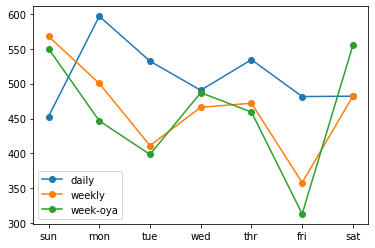

In [13]:
# naive forecast strategies for the power usage dataset
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s=0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores]) 
    print('%s: [%.3f] %s' % (name, score, s_scores))
    
# evaluate a single model
def evaluate_model(model_func, train, test):
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = model_func(history)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    predictions = array(predictions)
    # evaluate predictions days for each week
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores

# daily persistence model
def daily_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    # get the total active power for the last day
    value = last_week[-1, 0]
    # prepare 7 day forecast
    forecast = [value for _ in range(7)]
    return forecast

# weekly persistence model
def weekly_persistence(history):
    # get the data for the prior week
    last_week = history[-1]
    return last_week[:, 0]

# week one year ago persistence model
def week_one_year_ago_persistence(history):
    # get the data for the prior week
    last_week = history[-52]
    return last_week[:, 0]

if __name__ == '__main__':
    # load the new file
    dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
    # split into train and test
    train, test = split_dataset(dataset.values)
    # define the names and functions for the models we wish to evaluate
    models = dict()
    models['daily'] = daily_persistence
    models['weekly'] = weekly_persistence
    models['week-oya'] = week_one_year_ago_persistence
    # evaluate each model
    days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat'] 
    for name, func in models.items():
        # evaluate and get scores
        score, scores = evaluate_model(func, train, test)
        # summarize scores
        summarize_scores(name, score, scores)
        # plot scores
        pyplot.plot(days, scores, marker='o', label=name) # show plot
    pyplot.legend()
    pyplot.show()

In [16]:
import numpy as np
np.shape(train)

(159, 7, 8)

In [17]:
np.shape(test)

(46, 7, 8)

## 17.8 Summary
In this tutorial, you discovered how to develop a test harness for the household power consumption dataset and evaluate three naive forecast strategies that provide a baseline for more sophisticated algorithms. Specifically, you learned:
- How to load, prepare, and downsample the household power consumption dataset ready for modeling.
- How to develop metrics, dataset split, and walk-forward validation elements for a robust test harness for evaluating forecasting models.
- How to develop and evaluate and compare the performance a suite of naive persistence forecasting methods.